#### Utility Functions

In [2]:
import json
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import numpy as np
import mujoco
import mujoco_viewer
import cv2,os
import sys
sys.path.append('../')
""" FOR MuJoCo """
from models.utils.util import  *
from models.env.manipulator_agent import ManipulatorAgent
""" FOR ONROBOT RG2 """
from pymodbus.client.sync import ModbusTcpClient  
""" FOR MODERN DRIVER """
import roslib; roslib.load_manifest('ur_driver')
import rospy
""" FOR UR5 """
from models.realrobot.gripper import openGrasp, closeGrasp, resetTool
from models.realrobot.RealRobot import RealRobot

def compute_xyz(depth_img, camera_info):

    # x, fy, px, py
    fx = camera_info[0]
    fy = camera_info[1]
    cx = camera_info[2]
    cy = camera_info[3]

    height = depth_img.shape[0]
    width = depth_img.shape[1]

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img * 0.001 # Convert to meters
    x_e = (indices[..., 1] - cx) * z_e / fx 
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([z_e, -x_e, -y_e], axis=-1) # [H x W x 3] 
    return xyz_img

#### Instantiate Real UR robot and open Gripper

In [3]:
rospy.init_node('Pick_n_Place')
real_robot = RealRobot()
graspclient = ModbusTcpClient('192.168.0.4') 

In [4]:
joint_value = real_robot.joint_list.position
print(f"joint value: {joint_value}")

joint value: (-1.1745694319354456, -2.1283041439452113, 2.417136017476217, 0.9670702654072265, 0.9351379871368408, -1.070470158253805)


#### Sync with MuJoCo

In [5]:
xml_path = '../asset/ur5e/realworld.xml'
MODE = 'window' ################### 'window' or 'offscreen'
env = ManipulatorAgent(rel_xml_path=xml_path,VERBOSE=False, MODE=MODE)
env.close_viewer()

MODE: window


In [6]:
# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0.395])
env.model.body('front_object_table').pos = np.array([-38+0.6,-80,0])
env.model.body('side_object_table').pos = np.array([-0.38-2.4,0,0])
env.model.body('side_short_object_table').pos = np.array([0.38+0.4,0,0])

env.model.body('ur_base').pos = np.array([0.18,0,0.79])
for body_name in ['base_table','front_object_table','side_object_table']:
    geomadr = env.model.body(body_name).geomadr[0]
    env.model.geom(geomadr).rgba[3] = 1.0
print ("Ready.")

Ready.


### Solve IK

In [7]:
env.forward(q=joint_value, joint_idxs=env.idxs_forward)
print(env.get_p_body('ur_tcp_link'))
print(np.rad2deg(r2rpy(env.get_R_body('ur_tcp_link'))))

[4.99014082e-01 7.59045778e-06 9.64438102e-01]
[-1.30082820e+02  5.43536294e-02  8.99953547e+01]


In [15]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])

p_trgt = np.array([ 0.5, 0,  0.965])
p_trgt = np.array([ 0.675, 0,  0.85])
R_trgt = rpy2r(np.radians([-180, 0, 90])) # Up-Right Grasping
IK_P = True
IK_R = True

q_init = np.array(joint_value)
q_ik, ik_done = env.solve_ik_repel(
    body_name='ur_tcp_link',p_trgt=p_trgt,R_trgt=R_trgt,
    IK_P=IK_P,IK_R=IK_R, q_init=init_configurations,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    RESET=False,DO_RENDER=True,render_every=1,th=1*np.pi/180.0,err_th=1e-3, repulse=100, BREAK_TICK=2000)

env.close_viewer()
print(q_ik)
env.forward(q=q_ik, joint_idxs=env.idxs_forward)
print(env.get_p_body('ur_tcp_link'))

MODE: window
[-6.41363032e-01 -1.15244289e+00  2.70427236e+00 -1.55212554e+00
  9.29296030e-01  1.79191839e-04]
[ 6.74499871e-01 -3.56830342e-04  8.49482178e-01]


In [16]:
q_ik

array([-6.41363032e-01, -1.15244289e+00,  2.70427236e+00, -1.55212554e+00,
        9.29296030e-01,  1.79191839e-04])

MODE: window
Pressed ESC
Quitting.


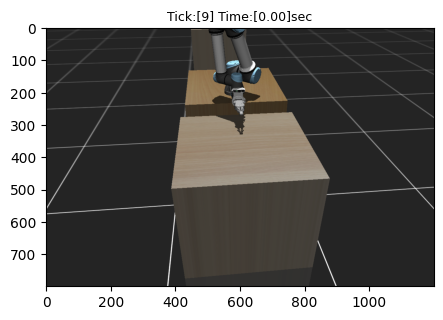

Done.


In [12]:
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=174.08,distance=2.76,elevation=-33,lookat=[0.1,0.05,0.16],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
env.forward(q=joint_value, joint_idxs=env.idxs_forward)
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]

tick = 0
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    tick = tick + 1
    env.forward(q=init_configurations, joint_idxs=env.idxs_forward)
    # Render
    p_tcp,R_tcp = env.get_pR_body(body_name='ur_tcp_link')
    p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
    p_base,R_base = env.get_pR_body(body_name='ur_base')
    env.render()
    if env.loop_every(HZ=1) or (tick == 1):
        scene_img = env.grab_image()
# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")

In [13]:
env.get_p_body('ur_tcp_link')

array([ 6.50019270e-01, -7.22548893e-06,  8.40053858e-01])

In [16]:
q_ik

array([-1.17291159, -2.12601153,  2.41418378,  0.96829606,  0.93633773,
       -1.06900867])

shutdown request: [/Pick_n_Place] Reason: new node registered with same name


In [17]:
np.rad2deg([-0.71455208, -1.79215948,  2.2971879,   0.72709997,  1.28995942, -0.66632508])

array([ -40.94081843, -102.68317442,  131.61917142,   41.65975957,
         73.90923051,  -38.17761487])

qvel_deg:[120.00]deg/sec L_interp:[3639] HZ:[500] time_max:[7.28]sec


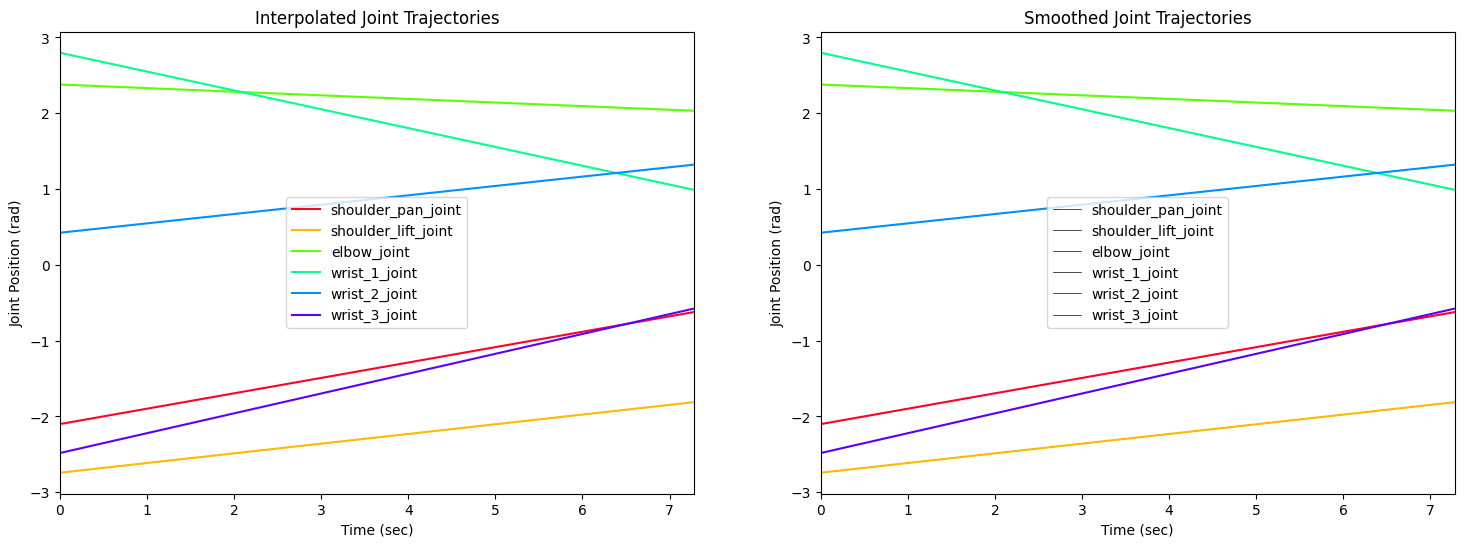

In [ ]:
from models.utils.util import get_interp_const_vel_traj
from models.utils.grpp import GaussianRandomPathClass, kernel_levse

# desired joint velocity (deg/sec)
qvel_rad = np.deg2rad(120)
HZ = 500

times,q_traj = get_interp_const_vel_traj(
    (np.vstack([joint_value, q_ik])),
    vel=np.radians(15),HZ=env.HZ)
L_interp = q_traj.shape[0]
print ("qvel_deg:[%.2f]deg/sec L_interp:[%d] HZ:[%d] time_max:[%.2f]sec"%
       (np.rad2deg(qvel_rad),L_interp,HZ,times[-1]))

G = GaussianRandomPathClass(name='LGRP',kernel=kernel_levse)
G.set_data(t_anchor    = times.reshape((-1,1)),
           x_anchor    = q_traj,
           l_anchor    = np.ones((len(times),1)),
           t_test      = times.reshape((-1,1)),
           l_test      = np.ones((len(times),1)),
           hyp_mean    = {'g':1.0,'l':1.0,'w':1e-6},
           hyp_var     = {'g':1.0,'l':1.0,'w':1e-6},
           APPLY_EPSRU = False
          )

qs_smooth = G.mean_test

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_ctrl)])
for d_idx in range(env.n_ctrl-1):
    color=colors[d_idx,:]
    plt.plot(times,qs_smooth[:,d_idx],'-',color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Interpolated Joint Trajectories")
plt.xlim(0,times[-1]); plt.legend(fontsize=10); 
# plt.show()

# plt.figure(figsize=(8,3))
plt.subplot(1,2,2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,env.n_ctrl)])
for d_idx in range(env.n_ctrl-1):
    color=colors[d_idx,:]
    plt.plot(times,qs_smooth[:,d_idx],'-',color='k',lw=1/2,
             label='%s'%(env.rev_joint_names[d_idx]))
    plt.plot(times,qs_smooth[:,d_idx],'-',color=color)
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Smoothed Joint Trajectories")
plt.xlim(0,times[-1]); plt.legend(fontsize=10); plt.show()

In [ ]:
# Set to Initial Pose.
real_robot.move_capture_pose();time.sleep(1)

Waiting for server...
Connected to server


ROSInterruptException: rospy shutdown

In [ ]:
real_robot.main(joint_list=qs_smooth)
